# Exploratory Data Analysis

## Dataset File Structure and Class Proportions

FIrst I will investigate the file structure of the dataset. Below I do so by printing out the directory tree for the dataset.

In [1]:
# Set the path to the dataset
root_path = '../data/FLAME Dataset - Shamsoshoara'

In [2]:
import os

# Define a funtion that prints out the tree for a given directory,
# showing only subdirectories and file counts

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}-{}'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        filecount = len(files)
        if filecount>0:
            print(f'{subindent}-{filecount} files')

list_files('../data/FLAME_Dataset_subset')

-FLAME_Dataset_subset
    -Test
        -Fire
            -353 files
        -No_Fire
            -211 files
    -Training
        -Fire
            -1574 files
        -No_Fire
            -889 files


As per the above, the dataset is split into Test and Training directories, each of which are further subdivided into Fire and No_Fire classed images. Examining the file counts clearly shows that there is a significant class imbalance between Fire and Non-Fire images, and that the Fire Class is overrepresented in the training set relative to the Test set. This may have an adverse impact on test specificity later on, as it may influence the CNN to class images as Fire (positive) less often

## Dataset Pixel Dimensions

Next, I will plot the pizel sizes of all of the images in the dataset in $\mathbb{R}^2$

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define a function that returns the pixel dimensions of an image as a list
def get_dims(im_path):
    im = Image.open(im_path)
    arr = np.array(im)
    h,w,c = arr.shape
    return [h,w]

In [5]:
# Loop through the entire dataset
## Runtime on whole dataset: 14m 20s

height = []
width = []
train_test_flag = []
fire_flag = []

for s in ['Test','Training']:
    for c in ['Fire','No_Fire']:
        current_dir = os.path.join(root_path,s,c)
        file_seq = os.scandir(current_dir)
        for item in file_seq:
            train_test_flag.append(s)
            fire_flag.append(c)
            img_dims = get_dims(item.path)
            height.append(img_dims[0])
            width.append(img_dims[1])

# Summarise in dataframe
import pandas as pd
image_dim_df = pd.DataFrame(
    data = {
        'height':height,
        'width':width,
        'train_test':train_test_flag,
        'fire_noFire':fire_flag
    }
)


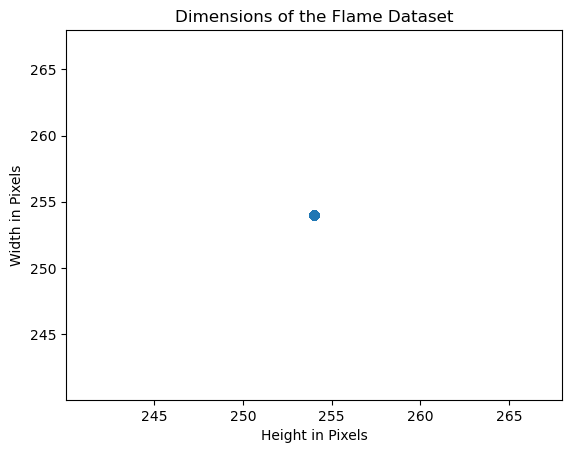

In [6]:
# Visualize the result
plt.scatter(image_dim_df['height'],image_dim_df['width'])
plt.xlabel('Height in Pixels')
plt.ylabel('Width in Pixels')
plt.title('Dimensions of the Flame Dataset')
plt.savefig('../figures/flame_dataset_image_dimensions.png')
plt.show()

In [7]:
# Test if there are any images that are not 255 X 255

((image_dim_df.height != 254) & (image_dim_df.width != 254)).any()

False

As shown above, all of the images in the data Fire_NoFire classification dataset have all been rescaled to 254x254 pixels

## Pixel Ranges

In [8]:
# Define function for getting pixel ranges

def get_range(img_path):
    im = Image.open(img_path)
    arr = np.array(im)
    min_val = arr.min()
    max_val = arr.max()
    return [min_val,max_val]

In [9]:
# Collect value ranges for the dataset
## Runtime entire dataset:
ranges = []

for s in ['Test','Training']:
    for c in ['Fire','No_Fire']:
        current_dir = os.path.join(root_path,s,c)
        file_seq = os.scandir(current_dir)
        for item in file_seq:
            img_val_range = get_range(item.path)
            ranges.append(img_val_range)

In [10]:
ranges_np = np.array(ranges)

In [11]:
# Add to the dataframe
image_dim_df['min_val'] = ranges_np[:,0]
image_dim_df['max_val'] = ranges_np[:,1]

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


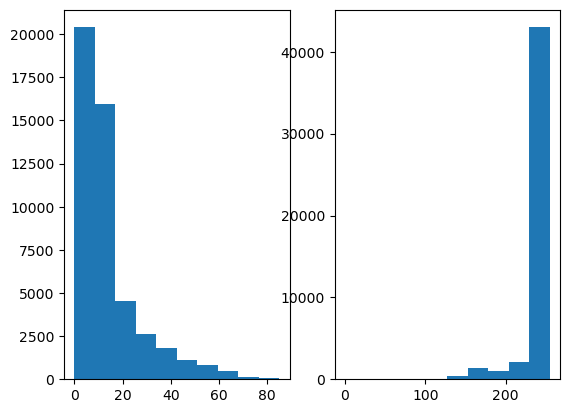

In [12]:
# Plot Histograms of minimums and maximums

fig, ax = plt.subplots(ncols=2)
ax[0].hist(image_dim_df.min_val)
ax[1].hist(image_dim_df.max_val)
fig.show()

In [13]:
image_dim_df[['min_val','max_val']].describe()

,min_val,max_val
count,47992.000000,47992.000000
mean,13.671279,244.164715
std,13.496918,21.795315
min,0.000000,0.000000
25%,5.000000,243.000000
50%,10.000000,253.000000
75%,16.000000,255.000000
max,85.000000,255.000000


Based on the above, the pixel ranges range from 0 to 255

## Image displaying

Display a random sample of images from the datset

In [14]:
img_paths = []
class_labels = []
for dirpath, dirname, filenames in os.walk(root_path):
    if filenames != []:
        for filename in filenames:
            class_labels.append(os.path.basename(dirpath))
            img_paths.append(os.path.join(dirpath,filename))

c:\Users\marti\anaconda3\envs\uda_project\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


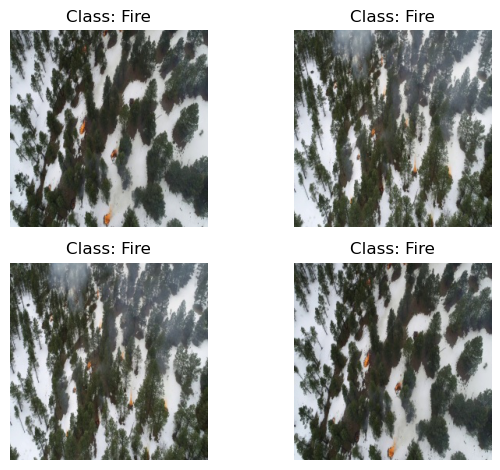

In [15]:
# Display 4 random images
img_inds = np.random.choice(np.arange(len(img_paths)),size=4,replace=False)

fig, ax = plt.subplots(nrows=2, ncols=2)
for i in [0,1]:
    img = Image.open(img_paths[img_inds[i]])
    ax[0,i].imshow(img)
    ax[0,i].set_axis_off()
    ax[0,i].set_title(f'Class: {class_labels[img_inds[i]]}')

for i in [0,1]:
    img = Image.open(img_paths[img_inds[i]])
    ax[1,i-1].imshow(img)
    ax[1,i-1].set_axis_off()
    ax[1,i-1].set_title(f'Class: {class_labels[img_inds[i]]}')
fig.tight_layout()
fig.show()

# Model Training and Scoring

## Pytorch CNN Model

I will now use Pytorch to build a CNN model for classifying the dataset

In [16]:
# Import the necessary modules to build the model
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

\<Explanation or learning rate choice\>

In [17]:
# Set model training parameters
batch_size = 100
learning_rate = 0.001

In [18]:
# Load the data
test_dir = os.path.join(root_path,'Test')
train_dir = os.path.join(root_path,'Training')

# Set the input data transformations, standardizing
transform = transforms.Compose(
    [
        transforms.ToTensor(), # convert to tensor, with values scaled to 0-1 per the documentation
        transforms.Resize((128,128),antialias=True), # Resize to 128 x 128 pixels
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize grey values within each channel
    ]    
)

# Define the ImageFolder objects using paths and transforms
train_folder = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=transform
)
test_folder = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=transform
)


In [19]:
# Check that the class labels have been set correctly
train_folder.classes

['Fire', 'No_Fire']

In [20]:
test_folder.classes

['Fire', 'No_Fire']

In [21]:
# Set random seed
np.random.seed(70103)

# Divide the dataset into batches
train_loader = torch.utils.data.DataLoader(
    dataset=train_folder,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_folder,
    batch_size=batch_size,
    shuffle=False
)

In [22]:
# Work out the convolved image shape for each layer

def output_shape(H,W,F,K,stride,padding):
    H_prime = ((H - F + 2*padding)/stride) + 1
    W_prime = ((W - K + 2*padding)/stride) + 1
    return [H_prime,W_prime]

## Layer 1
### Conv2d
shape = output_shape(128,128,5,5,1,2)
### MaxPool2d
shape = output_shape(shape[0],shape[1],2,2,2,0)
print('Layer 1:',shape[0],' x ',shape[1])

## Layer 2
### Conv2d
shape = output_shape(shape[0],shape[1],5,5,1,2)
### MaxPool2d
shape = output_shape(shape[0],shape[1],2,2,2,0)
print('Layer 2:',shape[0],' x ',shape[1])

Layer 1: 64.0  x  64.0
Layer 2: 32.0  x  32.0


In [23]:
# Convolutional neural network (two convolutional layers)
# This code was adapted from the code given in the week 2 coding demo
class UDA_CNN(nn.Module):
    def __init__(self, num_classes=2): # two classes, cats and dogs
        super(UDA_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                    in_channels = 3, # 3 in channels, R,G,B
                    out_channels = 16,
                    kernel_size=5,
                    stride=1,
                    padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16, 
                out_channels = 32, 
                kernel_size=5, 
                stride=1, 
                padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(32*32*32, num_classes)
        
    def forward(self, x):
        # Layer 1: 
        # input: 100 images, 128 \times 128 pixels
        # output: 100 images 16 batches, 64 \times 64
        out = self.layer1(x) 
        # Layer 2: 
        # input: 100 images, 16 batches, 64 \times 64 
        # output: 100 images, 32 batches, 32 \times 32
        out = self.layer2(out)
        # Reshape: 
        # output: 100 images, 32 *32*32
        out = out.reshape(out.size(0), -1)
        # Reshape: 
        # output: 100 images, 2 classes probabilities 
        out = self.fc(out)
        return out
      
model = UDA_CNN()

In [24]:
# Set random seed
np.random.seed(70103)
random.seed(70103)
torch.manual_seed(70103)

# Loss function
criterion = nn.CrossEntropyLoss()
# optimizer to update network parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(2):
    for i, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, 2, i+1, total_step, loss.item()))

Epoch [1/2], Step [10/394], Loss: 2.3973
Epoch [1/2], Step [20/394], Loss: 0.1087
Epoch [1/2], Step [30/394], Loss: 0.1977
Epoch [1/2], Step [40/394], Loss: 0.4611
Epoch [1/2], Step [50/394], Loss: 0.0398
Epoch [1/2], Step [60/394], Loss: 0.0725
Epoch [1/2], Step [70/394], Loss: 0.0622
Epoch [1/2], Step [80/394], Loss: 0.0171
Epoch [1/2], Step [90/394], Loss: 0.0228
Epoch [1/2], Step [100/394], Loss: 0.0601
Epoch [1/2], Step [110/394], Loss: 0.0429
Epoch [1/2], Step [120/394], Loss: 0.0531
Epoch [1/2], Step [130/394], Loss: 0.0339
Epoch [1/2], Step [140/394], Loss: 0.0158
Epoch [1/2], Step [150/394], Loss: 0.0556
Epoch [1/2], Step [160/394], Loss: 0.0986
Epoch [1/2], Step [170/394], Loss: 0.2980
Epoch [1/2], Step [180/394], Loss: 0.0194
Epoch [1/2], Step [190/394], Loss: 0.0010
Epoch [1/2], Step [200/394], Loss: 0.0424
Epoch [1/2], Step [210/394], Loss: 0.0609
Epoch [1/2], Step [220/394], Loss: 0.2773
Epoch [1/2], Step [230/394], Loss: 0.3662
Epoch [1/2], Step [240/394], Loss: 0.0543
E

In [26]:
# Test the model
model.eval()  # turn off batchnorm layer
with torch.no_grad(): # turn off gradient computation
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    
# Save the model checkpoint
torch.save(model.state_dict(), '../models/cnn_model_1.uda')

Test Accuracy of the model on the test images: 54.32285017987699 %
